# Machine Learning using Spark on Digital Music Service Data

## Table of Contents

I. [Part 1: Load and Clean Dataset](#part1)<br>
II. [Part 2: Exploratory Data Analysis](#part2)<br>
III. [Part 3: Feature Engineering](#part3)<br>
IV. [Part 4: Modeling](#part4)<br>
$\;\;\;\;\;\;$[4.1 ](#part4.1)<br>
$\;\;\;\;\;\;$[4.2 ](#part4.2)<br>
V. [Part 5: Conclusion](#part5)<br>

In [1]:
import findspark

findspark.init()

In [2]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
import re
import datetime
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [4]:
## https://pypi.org/project/httpagentparser/
# ! pip install httpagentparser

import httpagentparser

## <a class="anchor" id="part1"> Part 1: Load and Clean Dataset </a>

In this workspace, the dataset file is medium_sparkify_event_data.json. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [4]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

In [5]:
sparkify_data = 'medium-sparkify-event-data.json'

In [6]:
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
df.take(1)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')]

In [9]:
df.select('page').dropDuplicates().sort('page').show(30)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [10]:
df.select('userId').dropDuplicates().sort('userId').show(3)

+------+
|userId|
+------+
|      |
|    10|
|   100|
+------+
only showing top 3 rows



### Drop Rows with Missing Values

As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [12]:
df.count()

543705

In [95]:
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [96]:
df_valid.count()

543705

In [97]:
df_valid = df_valid.filter(df_valid["userId"] != "") 

In [98]:
df_valid.count()

528005

Change 'ts' to datetime

In [99]:
# get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
# df_valid = df_valid.withColumn('time', get_time(df_valid.ts))

df_valid = df_valid.withColumn('time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))

In [46]:
# Show min and max time in the data
df_valid.agg(min('time')).show(), df_valid.agg(max('time')).show()

+-------------------+
|          min(time)|
+-------------------+
|2018-09-30 19:00:11|
+-------------------+

+-------------------+
|          max(time)|
+-------------------+
|2018-11-30 18:01:06|
+-------------------+



(None, None)

In [50]:
# Create day of year column
df_valid = df_valid.withColumn('day', dayofyear('time').cast(IntegerType()))
# Create week of year column
df_valid = df_valid.withColumn('week', weekofyear('time').cast(IntegerType()))

In [33]:
# Create year column
df_valid = df_valid.withColumn('year', year(col('time')))
# Create month column
df_valid = df_valid.withColumn('month', month(col('time')))
# Create date column
df_valid = df_valid.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
# Create hour column
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_valid = df_valid.withColumn('hour', get_hour(df_valid.ts))

In [32]:
df_valid.agg(min(col('year'))).show(), df_valid.agg(max(col('year'))).show()

+---------+
|min(year)|
+---------+
|     2018|
+---------+

+---------+
|max(year)|
+---------+
|     2018|
+---------+



(None, None)

In [51]:
df_valid.take(1)

[Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', time=datetime.datetime(2018, 10, 8, 4, 36, 32), year=2018, month=10, date=datetime.date(2018, 10, 8), hour='4', churn_event=0, Downgrade_event=0, churn=1, downgrade=1, platform='iOS', browser='Safari', week=41, day=281)]

## <a class="anchor" id="part2"> Part 2: Exploratory Data Analysis </a>

When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark.

- **Define customer churn event and downgrade event**

In [102]:
df_valid.filter("page = 'Cancellation Confirmation'").count()

99

In [103]:
# Flag churn event
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

df_valid = df_valid.withColumn("churn_event", flag_churn_event("page"))

In [104]:
df_valid.filter("page = 'Submit Downgrade'").count()

117

In [105]:
# Flag downgrade event
flag_downgrade_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

df_valid = df_valid.withColumn("Downgrade_event", flag_downgrade_event("page"))

Flag userId who has non-zero churn and downgrade event

In [108]:
# Flag user with churn or downgrade event
windowval = Window.partitionBy('userId')
df_valid = df_valid.withColumn('churn', max('churn_event').over(windowval))
df_valid = df_valid.withColumn('downgrade', max('Downgrade_event').over(windowval))

In [112]:
df_valid.select(['userId', 'churn', 'downgrade']).dropDuplicates().show(10)

+------+-----+---------+
|userId|churn|downgrade|
+------+-----+---------+
|100010|    1|        1|
|200002|    1|        1|
|   296|    1|        1|
|   125|    0|        0|
|   124|    1|        1|
|    51|    1|        1|
|     7|    0|        0|
|200037|    1|        1|
|   169|    0|        0|
|   205|    0|        0|
+------+-----+---------+
only showing top 10 rows



In [38]:
# Users who have churned
df_valid.select(['userId','churn']).where(df_valid.churn == 1).dropDuplicates().take(3)

[Row(userId='100010', churn=1),
 Row(userId='200002', churn=1),
 Row(userId='296', churn=1)]

In [44]:
# Check churned user log history right before churn
df_valid.select(['userId','date','sessionId','page','churn_event','Downgrade_event']).where(df_valid.userId == '100010').tail(10)

[Row(userId='100010', date=datetime.date(2018, 10, 11), sessionId=166, page='NextSong', churn_event=0, Downgrade_event=0),
 Row(userId='100010', date=datetime.date(2018, 10, 11), sessionId=166, page='Thumbs Down', churn_event=0, Downgrade_event=0),
 Row(userId='100010', date=datetime.date(2018, 10, 11), sessionId=166, page='NextSong', churn_event=0, Downgrade_event=0),
 Row(userId='100010', date=datetime.date(2018, 10, 11), sessionId=166, page='NextSong', churn_event=0, Downgrade_event=0),
 Row(userId='100010', date=datetime.date(2018, 10, 11), sessionId=166, page='Roll Advert', churn_event=0, Downgrade_event=0),
 Row(userId='100010', date=datetime.date(2018, 10, 11), sessionId=166, page='NextSong', churn_event=0, Downgrade_event=0),
 Row(userId='100010', date=datetime.date(2018, 10, 11), sessionId=166, page='NextSong', churn_event=0, Downgrade_event=0),
 Row(userId='100010', date=datetime.date(2018, 10, 11), sessionId=166, page='Roll Advert', churn_event=0, Downgrade_event=0),
 Row(us

- **Churn rate**

In [113]:
user_count = df_valid.select('userId').distinct().count()
df_churn = df_valid.select(['churn','userId']).distinct().groupby('churn').count().orderBy(col('churn'),ascending=True)
df_churn = df_churn.withColumn('percentage', col('count')/user_count).toPandas()

In [115]:
df_churn

,churn,count,percentage
0,0,349,0.779018
1,1,99,0.220982


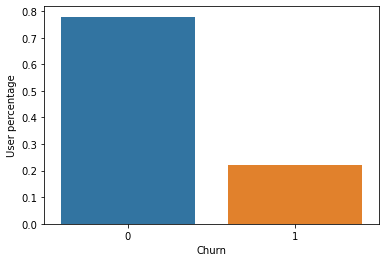

In [121]:
ax=sns.barplot(x='churn', y='percentage', data=df_churn)
ax.set_xlabel('Churn');
ax.set_ylabel('User percentage');

- **Churn by hour**

In [131]:
#Create a temporary view of SQL table from dataframe "df_valid"

df_valid.createOrReplaceTempView("df_cleaned")

In [132]:
churn_in_hour = spark.sql('''
          SELECT hour, COUNT(*) as churn_per_hour
          FROM df_cleaned
          WHERE churn = 1
          GROUP BY hour
          ORDER BY hour 
          '''
          )

In [133]:
df_churn_in_hour = churn_in_hour.toPandas()
df_churn_in_hour.head()

,hour,churn_per_hour
0,0,3741
1,1,3635
2,10,5319
3,11,5582
4,12,5785


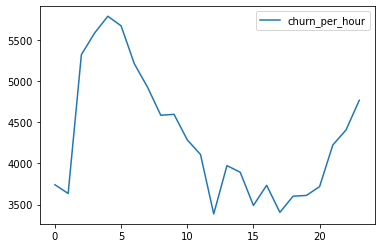

In [184]:
df_churn_in_hour.plot.line();

- **Churn by user account level**

In [245]:
churn_level = df_valid.groupby(['churn','level']).agg(countDistinct('userId').alias('count')).toPandas()
churn_level.head()

,churn,level,count
0,0,free,288
1,0,paid,246
2,1,paid,75
3,1,free,82


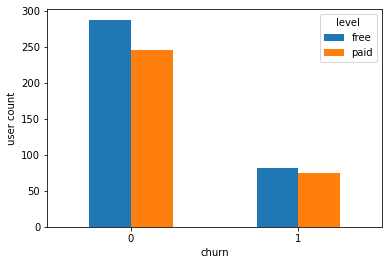

In [249]:
ax = churn_level.pivot(index='churn', columns='level', values='count').plot(kind='bar',rot=0);
ax.set_xlabel('churn');
ax.set_ylabel('user count');

- **User activity**

In [135]:
user_activity = spark.sql('''
          SELECT page, COUNT(*) as activity_count
          FROM df_cleaned
          GROUP BY page
          ORDER BY COUNT(*)
          '''
          )

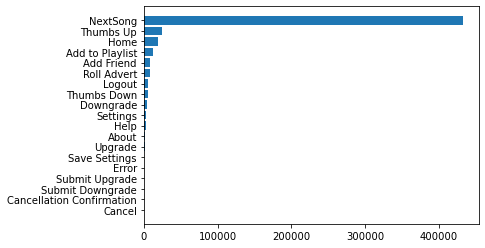

In [136]:
user_activity = user_activity.toPandas()
plt.barh(user_activity.page, user_activity.activity_count);

- **Churn by platform / Browser**

In [156]:
df_valid.select('userAgent').take(1)

[Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"')]

In [155]:
s = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"
print(httpagentparser.simple_detect(s))

('MacOS Macintosh X 10.9.4', 'Chrome 36.0.1985.125')


In [163]:
print(httpagentparser.detect(s))

{'platform': {'name': 'Mac OS', 'version': 'X 10.9.4'}, 'os': {'name': 'Macintosh'}, 'bot': False, 'flavor': {'name': 'MacOS', 'version': 'X 10.9.4'}, 'browser': {'name': 'Chrome', 'version': '36.0.1985.125'}}


In [166]:
httpagentparser.detect(s).get('platform').get('name')

'Mac OS'

In [169]:
df_valid = df_valid.withColumn('platform', udf(lambda x: httpagentparser.detect(x).get('platform').get('name'), StringType())('userAgent')) \
                   .withColumn('browser', udf(lambda x: httpagentparser.detect(x).get('browser').get('name'), StringType())('userAgent'))

In [170]:
df_valid.head()

Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', time=datetime.datetime(2018, 10, 8, 4, 36, 32), year=2018, month=10, date=datetime.date(2018, 10, 8), hour='4', churn_event=0, Downgrade_event=0, churn=1, downgrade=1, platform='iOS', browser='Safari')

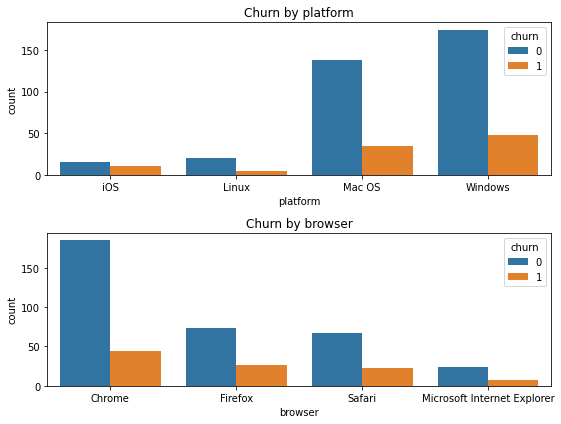

In [180]:
agentInfo = ['platform', 'browser']

fig, ax = plt.subplots(len(agentInfo), 1, figsize=(8,6))
for i, u in enumerate(agentInfo):
    data = df_valid.groupby(['churn', u]).agg(countDistinct('userId').alias('count')).toPandas()
    sns.barplot(x=u, y='count', hue='churn', data=data, ax=ax[i])
    ax[i].set_title('Churn by {}'.format(u))
plt.tight_layout()
plt.show()

- **Churn by Customer Activity**

In [201]:
user_ActLike = spark.sql('''
          SELECT userId, churn, gender, COUNT(page) as ActLike_count
          FROM df_cleaned
          where page="NextSong" 
          OR page="Thumbs Up" 
          OR page="Add to Playlist"
          GROUP BY userId, churn, gender
          ORDER BY COUNT(*)
          '''
          )

In [202]:
user_ActLike = user_ActLike.toPandas()
user_ActLike.head(5)

,userId,churn,gender,ActLike_count
0,200044,0,M,1
1,200033,0,F,6
2,100032,1,M,7
3,200035,0,F,9
4,63,0,F,12


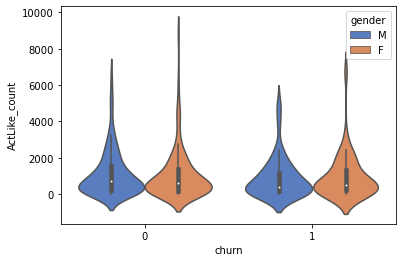

In [203]:
ax = sns.violinplot(x="churn", y="ActLike_count", hue="gender",
                    data=user_ActLike, palette="muted")

In [211]:
user_Dislike = df_valid.where('page == "Submit Downgrade" OR page == "Thumbs Down"').groupby(['userId', 'churn', 'gender']).count().toPandas()
user_Dislike.rename(columns={'count':'ActDislike_count'}, inplace=True)
user_Dislike.head()

,userId,churn,gender,ActDislike_count
0,100010,1,F,3
1,200002,1,M,5
2,125,0,M,1
3,124,1,F,15
4,51,1,M,1


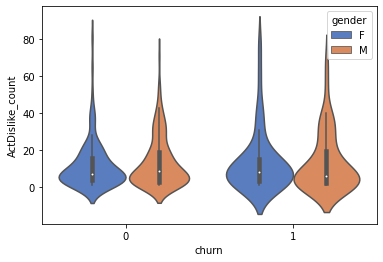

In [213]:
ax = sns.violinplot(x="churn", y="ActDislike_count", hue="gender",
                    data=user_Dislike, palette="muted")

## <a class="anchor" id="part3"> Part 3: Feature Engineering </a>

Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.

* Write a script to extract the necessary features from the smaller subset of data
* Ensure that your script is scalable, using the best practices discussed in Lesson 3
* Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

**1. Define function to load, clean and wrangle data**

In [52]:
def load_clean_data(file):
    '''
    Function:
    Load, clean and wrangle data
    
    INPUT:
    file - input file name
    
    Output:
    df_valid - 2D dataframe  
    
    '''
    # Load data
    df = spark.read.json(file)
    
    # Drop rows with missing value in 'userId' and 'sessionId'
    df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])
    df_valid = df_valid.filter(df_valid["userId"] != "") 
    
    # Convert col 'ts' to datetime 
    df_valid = df_valid.withColumn('time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
    # Create day of year column
    df_valid = df_valid.withColumn('day', dayofyear('time').cast(IntegerType()))
    # Create week of year column
    df_valid = df_valid.withColumn('week', weekofyear('time').cast(IntegerType()))
    
    # Flag churn event
    flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df_valid = df_valid.withColumn("churn_event", flag_churn_event("page"))
    
    # Flag downgrade event
    flag_downgrade_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df_valid = df_valid.withColumn("Downgrade_event", flag_downgrade_event("page"))
    
    # Flag user with churn or downgrade event
    windowval = Window.partitionBy('userId')
    df_valid = df_valid.withColumn('churn', max('churn_event').over(windowval))
    df_valid = df_valid.withColumn('downgrade', max('Downgrade_event').over(windowval))
    
    # Parse 'userAgent' to new column 'platform' and 'browser'
    df_valid = df_valid.withColumn('platform', udf(lambda x: httpagentparser.detect(x).get('platform').get('name'), StringType())('userAgent')) \
                   .withColumn('browser', udf(lambda x: httpagentparser.detect(x).get('browser').get('name'), StringType())('userAgent'))
    
    print('Number of rows in the cleaned data: {}'.format(df_valid.count()))
    
    return df_valid

## <a class="anchor" id="part4"> Part 4: Modeling </a>

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [6]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

In [53]:
sparkify_data = 'medium-sparkify-event-data.json'
df_valid = load_clean_data(sparkify_data)

Number of rows in the cleaned data: 528005


In [54]:
df_valid.take(1)

[Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', time=datetime.datetime(2018, 10, 8, 4, 36, 32), day=281, week=41, churn_event=0, Downgrade_event=0, churn=1, downgrade=1, platform='iOS', browser='Safari')]

In [8]:
# TODO: write your code for this step
train, validation = df.randomSplit([0.9, 0.1], seed=42)

### Step 2. Build Pipeline

In [20]:
#build pipeline
Gender_indexer = StringIndexer(inputCol="gender", outputCol='Gender_Index')
User_indexer = StringIndexer(inputCol="userAgent", outputCol='User_Index')
Page_indexer = StringIndexer(inputCol="page", outputCol='Page_Index')
Gender_encoder = OneHotEncoder(inputCol='Gender_Index', outputCol='Gender_Vec')
User_encoder = OneHotEncoder(inputCol='User_Index', outputCol='User_Vec')
Page_encoder = OneHotEncoder(inputCol='Page_Index', outputCol='Page_Vec')
assembler = VectorAssembler(inputCols=["Gender_Vec", "User_Vec", "Page_Vec", "status"], outputCol="features")
indexer = StringIndexer(inputCol="Churn", outputCol="label")

In [21]:
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[Gender_indexer, User_indexer, Page_indexer, Gender_encoder, User_encoder, Page_encoder, assembler, indexer, lr])

### Step 3. Tune Model
On the first 90% of the data let's find the most accurate logistic regression model using 3-fold cross-validation with the following parameter grid:

- CountVectorizer vocabulary size: `[1000, 5000]`
- LogisticRegression regularization parameter: `[0.0, 0.1]`
- LogisticRegression max Iteration number: `[10]`

In [23]:
# TODO: write your code for this step
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

### Step 4: Compute Accuracy of Best Model

In [24]:
# TODO: write your code for this step
cvModel_q1 = crossval.fit(train)

In [25]:
cvModel_q1.avgMetrics

[1.0, 0.9997126027454916]

In [26]:
results = cvModel_q1.transform(validation)

In [27]:
print(results.filter(results.label == results.prediction).count())
print(results.count())

53100
53100


In [14]:
3919/10062

0.3894851918107732

## <a class="anchor" id="part5"> Part 5: Conclusion </a>